In [3]:

import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
from postprocessing import post_processing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_dir = 'data/processed/census_income_learn.csv'
test_dir = 'data/processed/census_income_test.csv'

# Load the train/test data
print("Train data: ###############################")
X_train, y_train = post_processing(train_dir, get_dummies= False)
# X_train = X_train.astype(int)
print(f'X_train shape: {X_train.shape}')

print("\nTest data: ###############################")
X_test, y_test = post_processing(test_dir, get_dummies= False)
# X_test = X_test.astype(int)
print(f'X_test shape: {X_test.shape}')

Train data: ###############################


Number of numeric columns: 8
Number of numeric columns: 20
X_train shape: (143468, 27)

Test data: ###############################


Number of numeric columns: 8
Number of numeric columns: 20
X_test shape: (72023, 27)


In [3]:
df = pd.concat([X_train, y_train], axis=1)
df[df['age'] >= 18]['target'].value_counts(normalize= True)

target
1    0.913709
0    0.086291
Name: proportion, dtype: float64

In [4]:
def plot_sorted_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple =(4, 3), save:bool = False):
    """
    Create a sorted percentage distribution plot
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)

    # Calculate proportions and sort categories
    proportions = df.groupby(x)[hue].mean().sort_values(ascending=False)
    sorted_categories = proportions.index.tolist()

    # Create the plot with sorted categories
    sns.histplot(
        data=df, 
        x=df[x].astype('category').cat.reorder_categories(sorted_categories), 
        hue=hue, 
        stat='percent', 
        multiple="fill"
    )

    plt.ylabel('Percentage')
    plt.legend(labels=['Under 50K', 'Above 50K'], title='Income Level')
    plt.xticks(rotation=45, ha='right')
    if save:
        plt.savefig(f'{x}_income')
    pass


def plot_kde_distribution(df: pd.DataFrame, x: str, hue: str = 'target', figsize: tuple = (4,3), 
                         fill: bool = True, alpha: float = 0.5, common_norm: bool = False,
                         title: str = None, save: bool = False):
    """
    Create a KDE plot for numerical variables
    
    Parameters:
    df (DataFrame): Input dataframe
    x (str): Column name for x-axis
    hue (str): Column name for hue/color separation
    figsize (tuple): Figure size (width, height)
    fill (bool): Whether to fill the KDE plot
    alpha (float): Transparency of the fill
    common_norm (bool): Whether to normalize the KDE plots together
    title (str): Plot title (optional)
    save (bool): Whether to save the plot
    """
    sns.set_theme(style="ticks")
    plt.figure(figsize=figsize)
    
    # Filter out zero values if present
    
    sns.kdeplot(data=df, x=x, hue=hue, fill=fill, alpha=alpha, common_norm=common_norm)
    
    plt.ylabel('Density')
    plt.legend(labels=['Under 50K', 'Above 50K'])
    
    # sns.despine()
    
    if save:
        plt.savefig(f'{x}_income_kde')
    pass

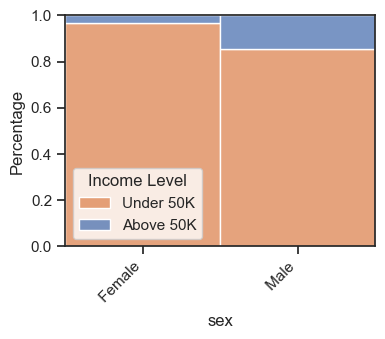

In [5]:
plot_sorted_distribution(df=df,
                         x= 'sex',
                         hue= 'target')

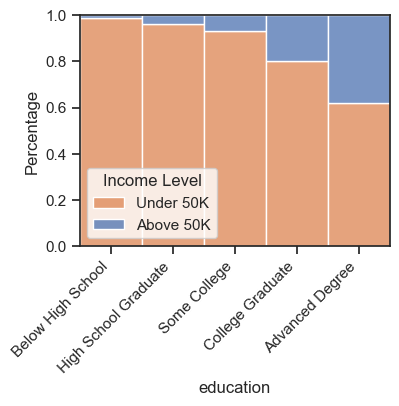

In [6]:
plot_sorted_distribution(df=df,
                         x= 'education')

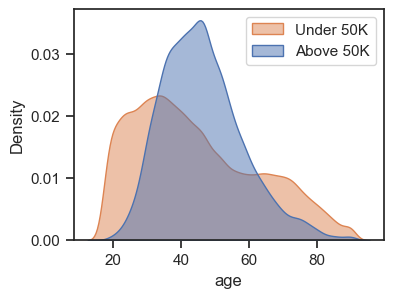

In [7]:
plot_kde_distribution(df , x = 'age')

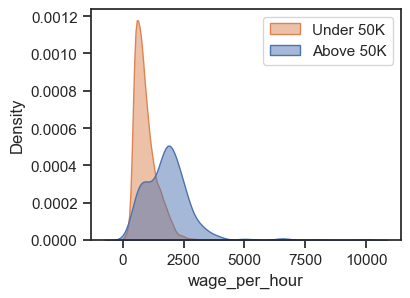

In [8]:
plot_kde_distribution(df[df['wage_per_hour']>0 ] , x = 'wage_per_hour')

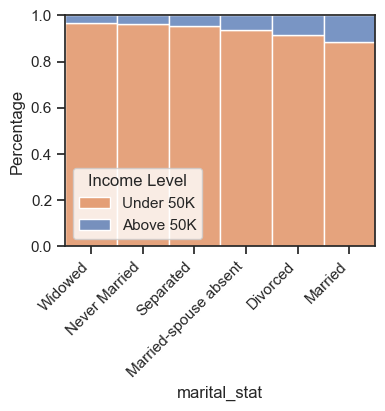

In [9]:
plot_sorted_distribution(df=df,
                         x= 'marital_stat')

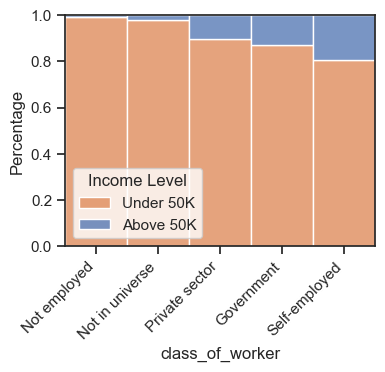

In [10]:
plot_sorted_distribution(df=df,
                         x= 'class_of_worker')

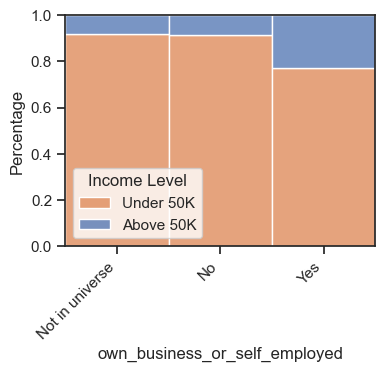

In [11]:
plot_sorted_distribution(df=df,
                         x= 'own_business_or_self_employed')

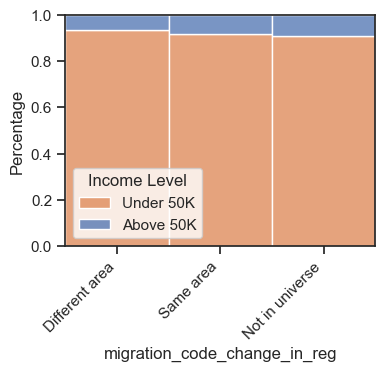

In [12]:

plot_sorted_distribution(df=df,
                         x= 'migration_code_change_in_reg')

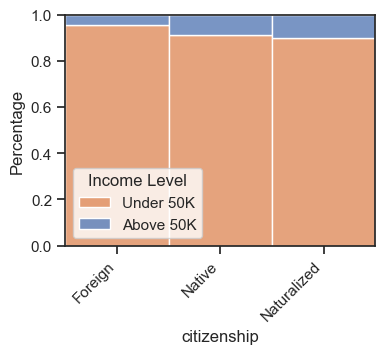

In [13]:
plot_sorted_distribution(df=df,
                         x= 'citizenship')

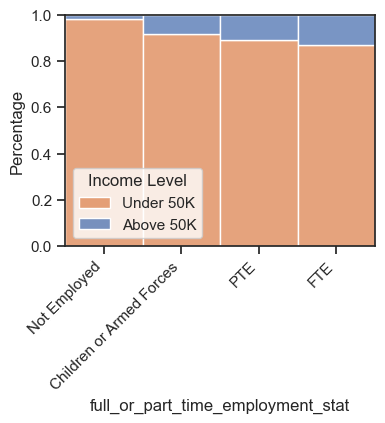

In [14]:
plot_sorted_distribution(df=df,
                         x= 'full_or_part_time_employment_stat')

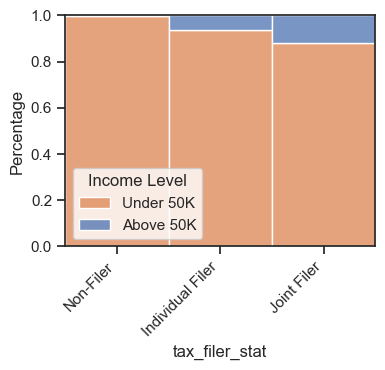

In [15]:
plot_sorted_distribution(df=df,
                         x= 'tax_filer_stat')

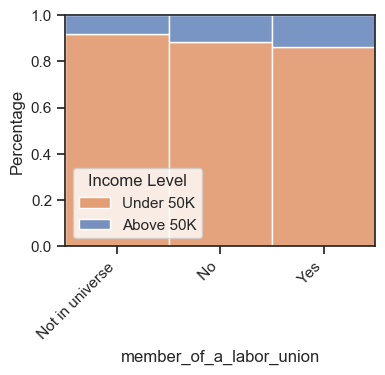

In [16]:
plot_sorted_distribution(df=df,
                         x= 'member_of_a_labor_union')

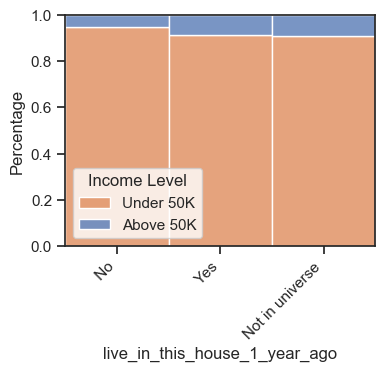

In [17]:
plot_sorted_distribution(df=df,
                         x= 'live_in_this_house_1_year_ago')


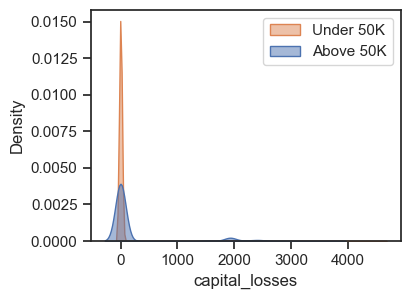

In [18]:
plot_kde_distribution(df,x= 'capital_losses')

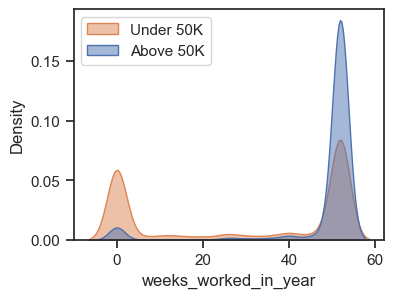

In [19]:
plot_kde_distribution(df,x= 'weeks_worked_in_year')


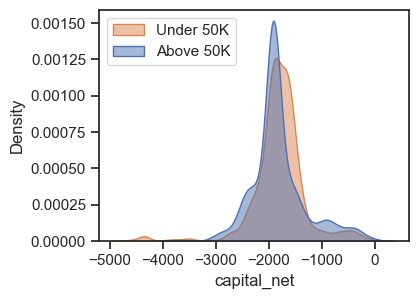

In [20]:
df['capital_net'] = df['capital_gains'] + df['dividends_from_stocks'] - df['capital_losses']
plot_kde_distribution(df[df['capital_net']< 0],x= 'capital_net')

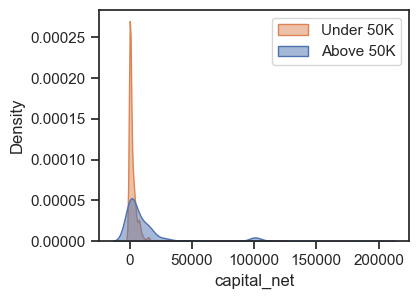

In [21]:
df['capital_net'] = df['capital_gains'] + df['dividends_from_stocks'] - df['capital_losses']
plot_kde_distribution(df[df['capital_net']> 0],x= 'capital_net')


In [22]:
df.get

<bound method NDFrame.get of         age  wage_per_hour  capital_gains  capital_losses  \
0        73              0              0               0   
1        58              0              0               0   
2        18              0              0               0   
5        48           1200              0               0   
6        42              0           5178               0   
...     ...            ...            ...             ...   
196288   39              0           6849               0   
196289   87              0              0               0   
196290   65              0           6418               0   
196291   47              0              0               0   
196293   32              0              0               0   

        dividends_from_stocks  num_persons_worked_for_employer  \
0                           0                                0   
1                           0                                1   
2                           0           

<Figure size 1500x1500 with 0 Axes>

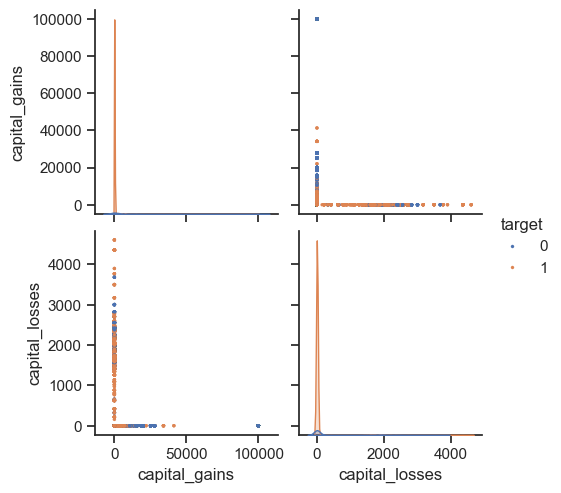

In [23]:
plt.figure(figsize=(15,15))
sns.pairplot(df, vars=['capital_gains', 'capital_losses'], hue='target', plot_kws={'s': 5, 'edgecolor': None})

#### Getting Correlation Values

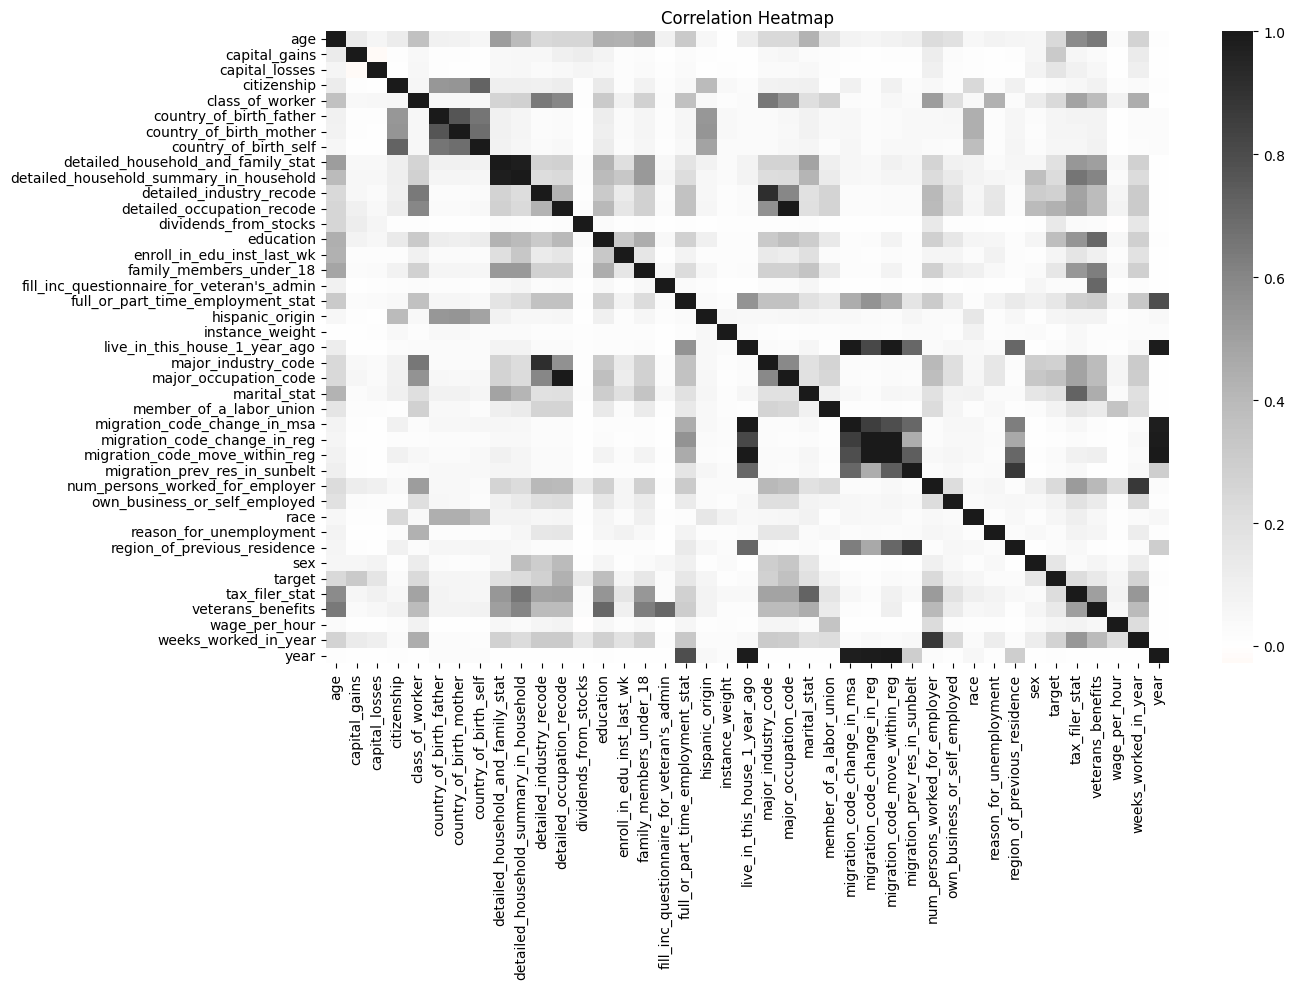

In [4]:
import json
filename = 'report/processed/census_income_learn.csv.json'
with open(filename) as j:
    corr = pd.DataFrame(json.load(j)['correlations']['auto'])
plt.figure(figsize=(14, 10))
plt.title("Correlation Heatmap")
sns.heatmap(corr, annot=False, cmap='RdGy', center=0, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns)
plt.xticks(rotation=90)
plt.yticks(rotation=0)  
plt.tight_layout()
plt.savefig('report/processed/corr_learn.jpg')

#### Getting Correlation with the **Target** variable

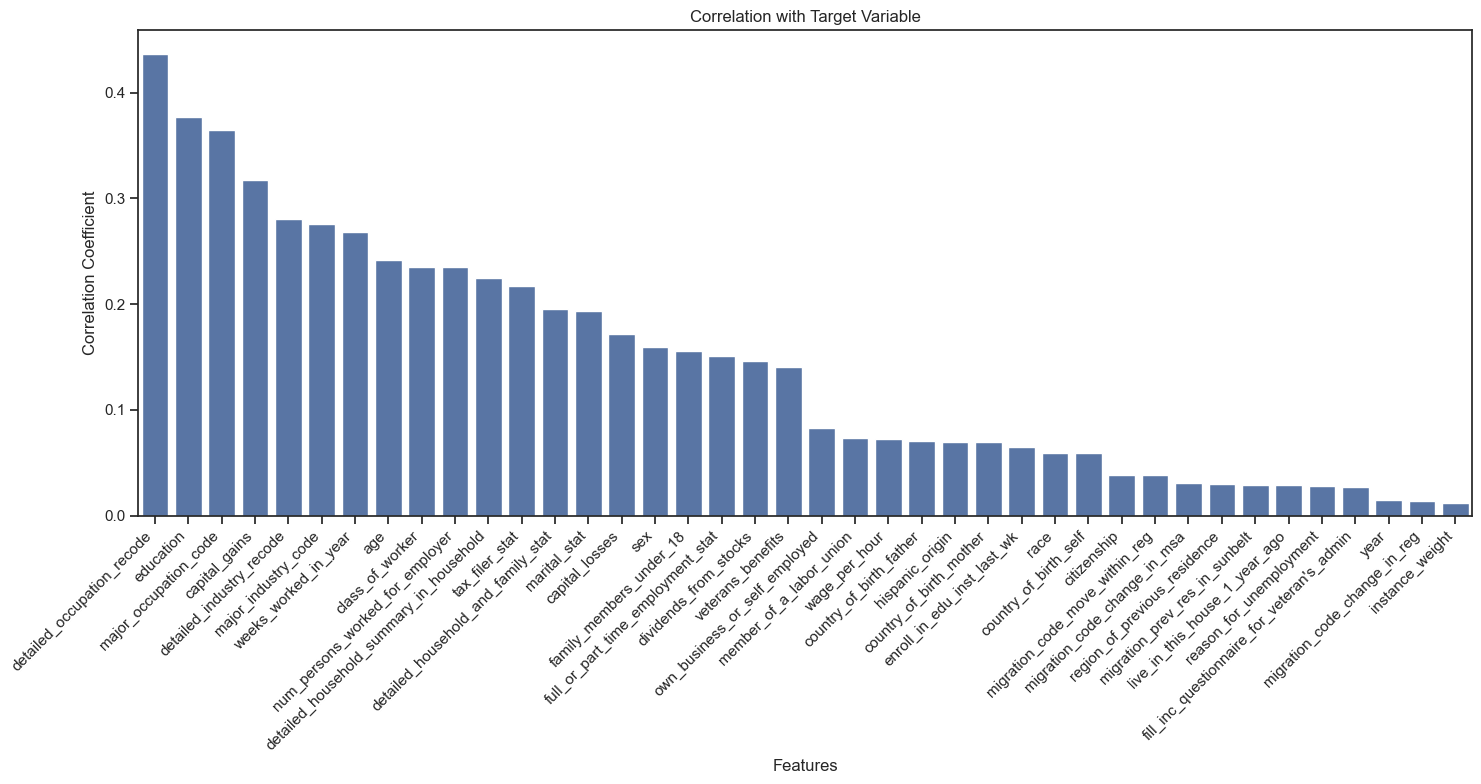

In [25]:

corr_target = corr['target']
corr_target.index = corr.columns
corr_target.drop('target', axis = 0, inplace= True)
corr_target = corr_target.sort_values(ascending= False) 
# Create figure with larger size for better readability
plt.figure(figsize=(15, 8))

# Create barplot with rotated x labels
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')

# Adjust layout to prevent label cutoff
plt.tight_layout()